In [3]:
import numpy as np

import torch

import deepxde as dde

import matplotlib.pyplot as plt

$f: R^2 -> R^3$

inputs:

- x -> 0
- y -> 1

outputs:
- v_x -> 0
- v_y -> 1
- p -> 2

In [19]:
L = 1
U0 = 1
ρ = 100   #  [kg]/[m³]
μ = 0.001   #  [Pa][s]

geom = dde.geometry.Rectangle(xmin=(0, 0), xmax=(L, L))

def top(X, on_boundary):
    return dde.utils.isclose(X[1], L) and on_boundary

def walls(X, on_boundary):
    return on_boundary and not top(X, on_boundary)

def all_boundary(X, on_boundary):
    return on_boundary


boundary_vy = dde.icbc.DirichletBC(
    geom,
    lambda X: 0,
    all_boundary,
    1
)

boundary_vx_top = dde.icbc.DirichletBC(
    geom,
    lambda X: U0,
    top,
    0
)

boundary_vx_bottom = dde.icbc.DirichletBC(
    geom,
    lambda X: 0,
    walls,
    0
)

soft_conditions = [
    boundary_vy,
    boundary_vx_top,
    boundary_vx_bottom,
]

In [17]:
def pde_lid_driven_dimensional(X,Y):

    # 1st derivative
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    # 2nd derivatives
    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    

    # Build equations
    pde_cont   = du_x + dv_y
    pde_u      = Y[:,0:1]*du_x +  Y[:,1:2]*du_y + dp_x/ρ - μ*(du_xx+ du_yy)
    pde_v      = Y[:,0:1]*dv_x +  Y[:,1:2]*dv_y + dp_y/ρ - μ*(dv_xx+ dv_yy)

    
    return [pde_u, pde_v, pde_cont]

In [20]:
net = dde.maps.FNN([2,] + [64]*6 + [3,], "silu", "Glorot uniform")

data = dde.data.PDE(
    geom,
    pde_lid_driven_dimensional,
    soft_conditions,
    num_boundary=1000,
    num_domain=2000,
    num_test=100,
)

model = dde.Model(data, net)

In [31]:
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(10_000)

Compiling model...
'compile' took 0.001299 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
13000     [2.38e-04, 1.45e-05, 3.80e-05, 4.15e-04, 2.56e-04, 5.38e-03]    [1.14e-04, 1.12e-05, 4.37e-05, 4.15e-04, 2.56e-04, 5.38e-03]    []  
14000     [4.76e-04, 1.32e-05, 6.29e-05, 4.09e-04, 3.15e-04, 5.32e-03]    [3.10e-05, 7.77e-06, 5.62e-05, 4.09e-04, 3.15e-04, 5.32e-03]    []  
15000     [2.56e-03, 9.88e-06, 3.51e-04, 3.96e-04, 1.29e-03, 4.79e-03]    [6.46e-05, 6.94e-06, 5.84e-05, 3.96e-04, 1.29e-03, 4.79e-03]    []  
16000     [2.57e-04, 1.25e-05, 5.08e-05, 5.71e-04, 2.10e-03, 4.60e-03]    [8.03e-05, 9.79e-06, 5.01e-05, 5.71e-04, 2.10e-03, 4.60e-03]    []  
17000     [2.03e-04, 1.85e-05, 4.30e-05, 5.26e-04, 2.33e-04, 4.89e-03]    [9.90e-05, 1.46e-05, 4.71e-05, 5.26e-04, 2.33e-04, 4.89e-03]    []  
18000     [1.79e-04, 1.92e-05, 3.11e-05, 3.67e-04, 2.89e-04, 5.62e-03]

KeyboardInterrupt: 

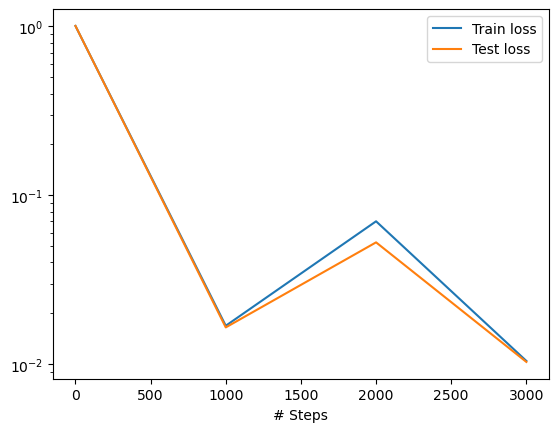

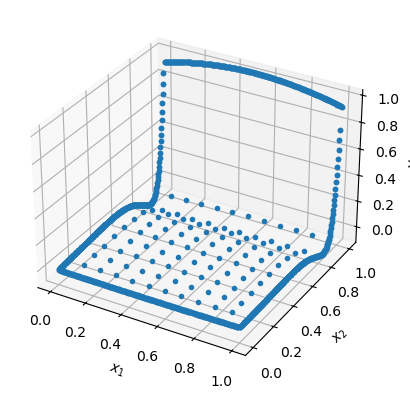

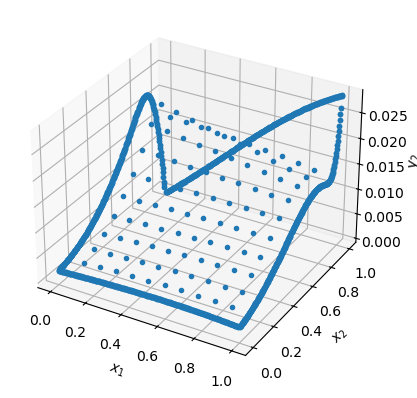

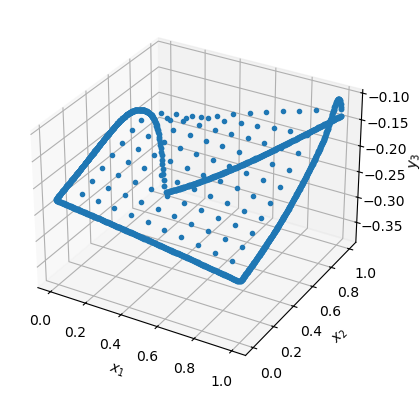

In [25]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

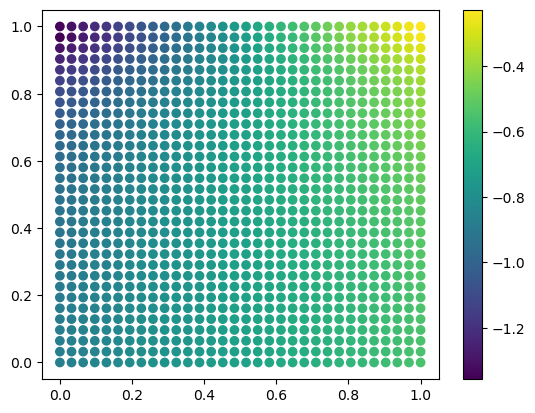

In [29]:
X = geom.uniform_points(1000)

x, y = X.T

u, v, p = model.predict(X).T

plt.scatter(x, y, c=p)
plt.colorbar()

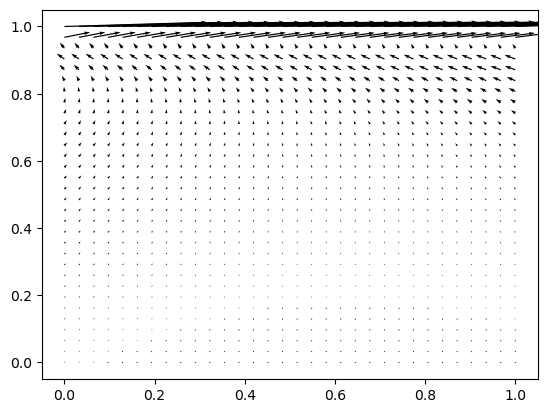

In [30]:
plt.quiver(x, y, u, v)